In [8]:
#FROM THE MIDREPORT

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Load dataset
df_top100 = pd.read_csv('../Steam_Project/steam_top100_cleaned_data_corrected.csv')

print("First 5 rows of the dataset:")
display(df_top100.head())

# Dataset overview
print("\nData Info:")
df_top100.info()

print("\nStatistical Summary:")
display(df_top100.describe())

# Clean numeric price
df_top100['price'] = pd.to_numeric(df_top100['price'], errors='coerce')
df_top100 = df_top100[(df_top100['price'] > 0) & (df_top100['price'] <= 210)]
df_top100.drop_duplicates(subset='appid', keep='first', inplace=True)

# Add review ratio columns
df_top100['total_reviews'] = df_top100['positive'] + df_top100['negative']
df_top100['positive_ratio'] = df_top100['positive'] / df_top100['total_reviews'].replace(0, 1)
df_top100['negative_ratio'] = df_top100['negative'] / df_top100['total_reviews'].replace(0, 1)

# Drop nulls and reset index
df_top100.dropna(subset=['name', 'genre'], inplace=True)
df_top100.reset_index(drop=True, inplace=True)

print("\nCleaned Data Sample:")
display(df_top100.head())

# === Discount + Review Historical Data (Used by Miguel for Hyp 4, 5, ML2) ===
review_folder = "ReviewHistory"
price_folder = "PriceHistory"
game_json = "100_Steam_Assortment.json"

with open(game_json, "r", encoding="utf-8") as f:
    games = json.load(f)

appid_type_map = {str(game["appid"]): game["type"] for game in games}
records = []

for appid in appid_type_map:
    review_path = os.path.join(review_folder, f"{appid}.csv")
    price_path = os.path.join(price_folder, f"{appid}.csv")

    if not os.path.exists(review_path) or not os.path.exists(price_path):
        continue

    try:
        review_df = pd.read_csv(review_path)
        price_df = pd.read_csv(price_path)

        review_df.columns = [col.strip().lower() for col in review_df.columns]
        price_df.columns = [col.strip().lower() for col in price_df.columns]

        if "final price" not in price_df.columns or "historical low" not in price_df.columns:
            continue

        review_df["date"] = pd.to_datetime(review_df["datetime"]).dt.date
        price_df["date"] = pd.to_datetime(price_df["datetime"]).dt.date

        review_grouped = review_df.groupby("date").agg({
            "positive reviews": "sum",
            "negative reviews": "sum"
        }).reset_index()

        price_grouped = price_df.groupby("date").agg({
            "final price": "last",
            "historical low": "last"
        }).reset_index()

        merged = pd.merge(review_grouped, price_grouped, on="date", how="inner")
        merged["discount_percent"] = 100 * (merged["final price"] - merged["historical low"]) / merged["final price"]
        merged["discount_percent"] = merged["discount_percent"].clip(lower=0)
        merged["review_volume"] = merged["positive reviews"] + merged["negative reviews"]
        merged = merged.dropna(subset=["discount_percent", "review_volume"])
        merged = merged[merged["review_volume"] > 0]

        for _, row in merged.iterrows():
            records.append({
                "appid": appid,
                "discount_percent": row["discount_percent"],
                "review_volume": row["review_volume"],
                "type": appid_type_map[appid]
            })

    except Exception as e:
        print(f"[{appid}] Error: {e}")
        continue

# Final DataFrame used for Hypothesis 4, Hypothesis 5, and ML2
df_discount_reviews = pd.DataFrame(records)

# Save for reuse in other cells (e.g., ML2)
df_discount_reviews.to_csv("merged_discount_review_data.csv", index=False)

First 5 rows of the dataset:


,appid,name,developer,publisher,price,positive,negative,genre
0,1623730,Palworld,Pocketpair,Pocketpair,29.99,353750,22031,Action
1,1063730,New World: Aeternum,Amazon Games,Amazon Games,79.99,196554,89844,Action
2,2358720,Black Myth: Wukong,Game Science,Game Science,59.99,1103540,38012,Action
3,1938090,Call of Duty: Modern Warfare II,"Treyarch, Raven Software, Beenox, High Moon St...",Activision,48.99,409407,288694,Action
4,550,Left 4 Dead 2,Valve,Valve,9.99,928245,23442,Action



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151092 entries, 0 to 151091
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   appid      151092 non-null  int64  
 1   name       151073 non-null  object 
 2   developer  150994 non-null  object 
 3   publisher  150529 non-null  object 
 4   price      151092 non-null  float64
 5   positive   151092 non-null  int64  
 6   negative   151092 non-null  int64  
 7   genre      151092 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 9.2+ MB

Statistical Summary:


,appid,price,positive,negative
count,1.510920e+05,151092.000000,1.510920e+05,151092.000000
mean,1.464639e+06,9.214309,1.403164e+03,191.953101
std,8.116983e+05,13.984803,1.890955e+04,2369.983623
min,1.000000e+01,0.270000,0.000000e+00,0.000000
25%,7.838600e+05,2.990000,5.000000e+00,1.000000
50%,1.366260e+06,5.990000,1.800000e+01,6.000000
75%,2.096840e+06,10.990000,1.020000e+02,29.000000
max,3.375310e+06,999.000000,1.357715e+06,288694.000000



Cleaned Data Sample:


,appid,name,developer,publisher,price,positive,negative,genre,total_reviews,positive_ratio,negative_ratio
0,1623730,Palworld,Pocketpair,Pocketpair,29.99,353750,22031,Action,375781,0.941373,0.058627
1,1063730,New World: Aeternum,Amazon Games,Amazon Games,79.99,196554,89844,Action,286398,0.686297,0.313703
2,2358720,Black Myth: Wukong,Game Science,Game Science,59.99,1103540,38012,Action,1141552,0.966701,0.033299
3,1938090,Call of Duty: Modern Warfare II,"Treyarch, Raven Software, Beenox, High Moon St...",Activision,48.99,409407,288694,Action,698101,0.586458,0.413542
4,550,Left 4 Dead 2,Valve,Valve,9.99,928245,23442,Action,951687,0.975368,0.024632


FileNotFoundError: [Errno 2] No such file or directory: '100_Steam_Assortment.json'

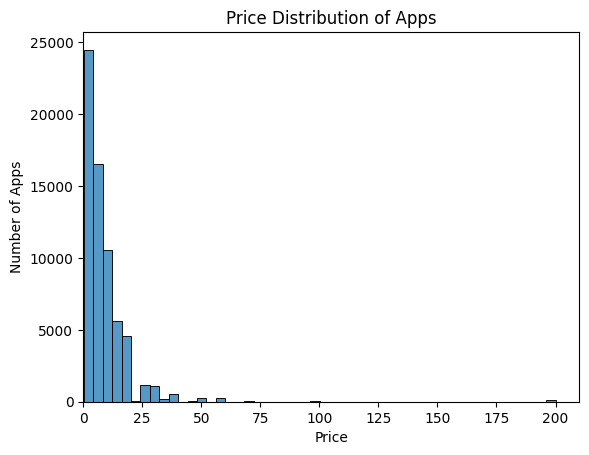

In [2]:
sns.histplot(df_top100['price'], bins=50)

plt.title("Price Distribution of Apps")
plt.xlim(0, 210)
plt.xlabel("Price")
plt.ylabel("Number of Apps")
plt.show()

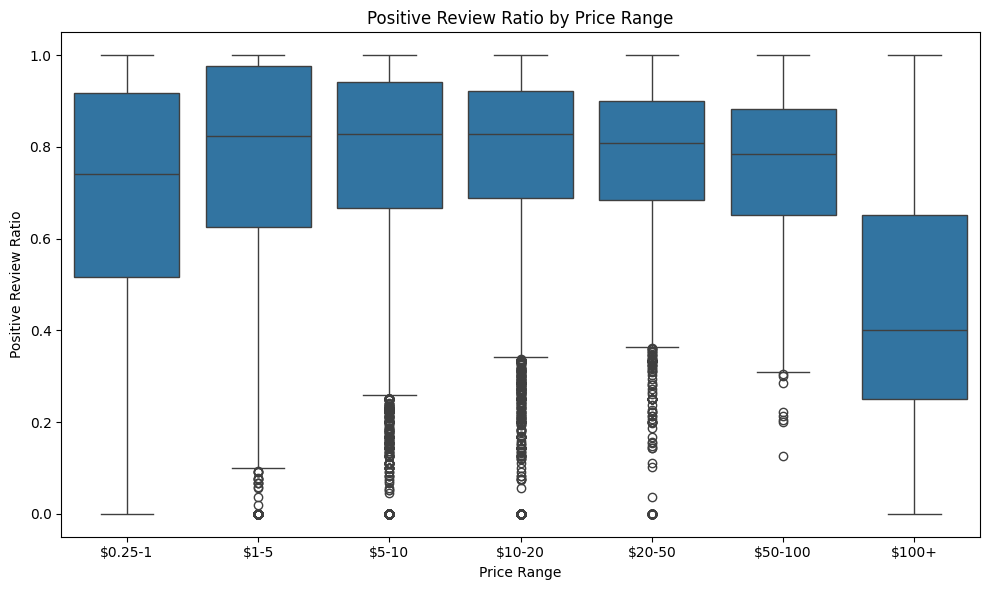

In [3]:
df_top100['price_bin'] = pd.cut(df_top100['price'], bins=[0, 1, 5, 10, 20, 50, 100, 200], labels=['$0.25-1', '$1-5', '$5-10', '$10-20', '$20-50', '$50-100', "$100+"], include_lowest=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='price_bin', y='positive_ratio', data=df_top100)
plt.title("Positive Review Ratio by Price Range")
plt.xlabel("Price Range")
plt.ylabel("Positive Review Ratio")
plt.tight_layout()
plt.show()

In [4]:
# [ML Analysis Code]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df_top100['is_highly_rated'] = df_top100['positive_ratio'] >= 0.8

X = df_top100[['price', 'total_reviews']]
y = df_top100['is_highly_rated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.51      0.01      0.02      6195
        True       0.53      0.99      0.69      6950

    accuracy                           0.53     13145
   macro avg       0.52      0.50      0.36     13145
weighted avg       0.52      0.53      0.37     13145



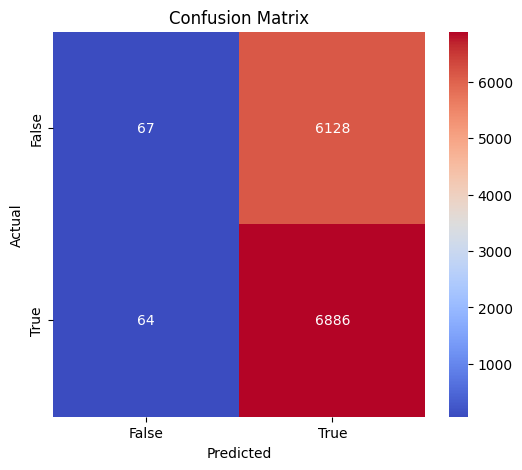

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

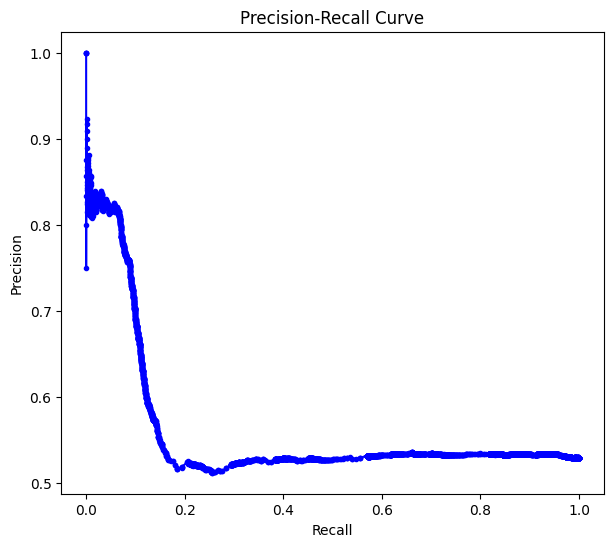

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, marker=".", color="b")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

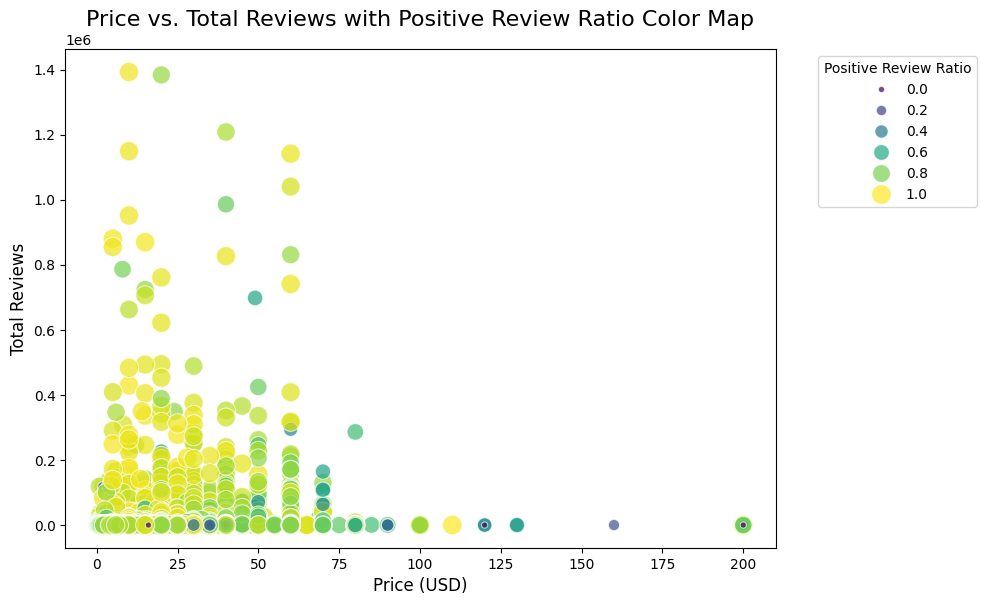

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size for better readability
plt.figure(figsize=(10, 6))

# Create the scatter plot
sns.scatterplot(data=df_top100, x='price', y='total_reviews', hue='positive_ratio', palette='viridis', size='positive_ratio', sizes=(20, 200), alpha=0.7)

# Customize the plot
plt.title('Price vs. Total Reviews with Positive Review Ratio Color Map', fontsize=16)
plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)
plt.legend(title='Positive Review Ratio', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()